# Dataset, forest roads detection

Спутниковый снимок был взят из открытых источников, с сайта https://scihub.copernicus.eu/dhus/#/home.
Получен спутником Sentinel-2, 25.08.2022, изображает лесную озерную местность провинции Альберта Канады. 
Покрывает участок площадью примерно 100 км x 100 км, координаты углов изображения: (55.94573440279175, -117.00032), (55.93320247103479, -115.24272), (54.947017819877004, -115.28601), (54.959098874363285, -117.000305).
Имеет разрешение 10м, размер 10980 пк x 10980 пк.
Для семантической сегментации было решено использовать изображения формата jp2, переведенные в более распространенный формат jpg, то есть мы работаем с rgb-изображениями, имеем 3 канала, соответствующие красному, зеленому и синему цветам.

Бинарная маска для снимка была сделана вручную, с помощью фото-редактора GIMP. 
На белом фоне размечены черные линии. Линии размечались на основе информации из карт OSM, Google Maps/Яндекс Карт. Дороги находились визуально, возможны погрешности и неточности. 
В ходе создания датасета мы убедились, что карты лесных дорог OSM действительно неполны. 

В этом ноутбуке произведена аугментация данных. 
Снимок и маска были поделены на 3 части для обучающей, валидационной и тестовой выборок, примерно в отношении 70:15:15.
В маске были изменены цвета: дороги стали обозначаться белым (класс 1), фон - черным (класс 0).
По каждой части пускалось окно размером 500 пк x 500 пк (5 км x 5 км) с шагом 250 пк.
Получившиеся изображения аугментировались поворотами (на 0, 90, 180, 270 градусов) и отражениями. Каждому кусочку 500x500 соответствует 8 изображений в соответствующей выборке. 
Данные о соответствиях фотографий и масок сохранялись в csv-файлах.

Размеры выборок (количество изображений):
- обучающая : 9744,
- валидационная : 1680,
- тестовая : 1680.

Устройство data.zip:
```
- data
    | - train
    |     | - images
    |     | - masks
    |     | - train_info.csv
    |
    | - validation
    |     | - images
    |     | - masks
    |     | - validation_info.csv
    |
    | - test
    |     | - images
    |     | - masks
    |     | - test_info.csv
    |
    | - image.jpg (снимок)
    | - mask.jpg (размеченная вручную маска)
    | - osm.jpg (дороги из osm для сравнения)
```

Данных получилось не очень много. 

**Ограничения:** Модель будет производить сегментацию изображений лесной местности в весенний/летний/осенний период (без снега), без помех в виде облаков.

In [1]:
import torch
import torchvision
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
image_path = './data/image.jpg'
mask_path = './data/mask.jpg'

image = torchvision.io.read_image(image_path)
mask = torchvision.io.read_image(mask_path)

## Train [0:10980, 0:7686]

In [3]:
train_image = image[:, :, :7686]
train_mask = mask[:, :, :7686]

In [4]:
train_image.shape

torch.Size([3, 10980, 7686])

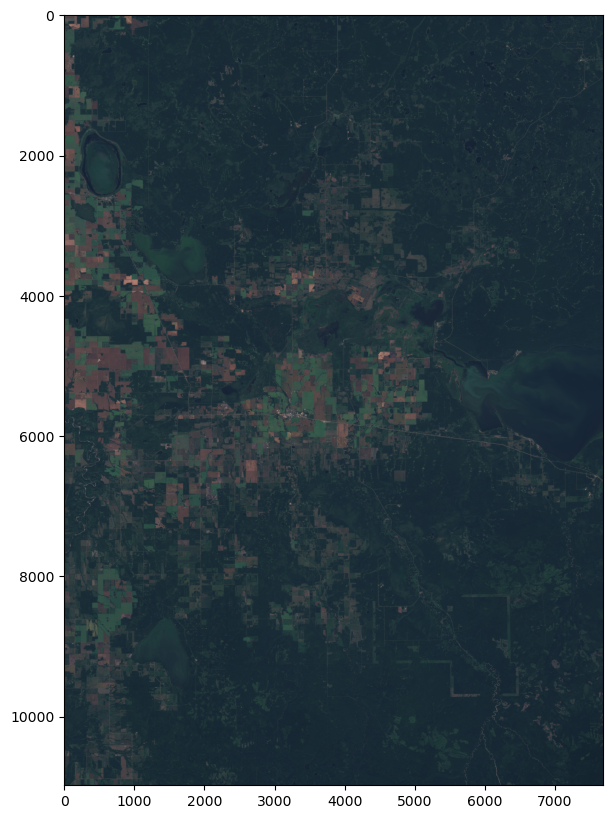

In [5]:
plt.figure(figsize=(8, 10))
plt.imshow(train_image.permute(1, 2, 0))
plt.show()

In [6]:
train_mask.shape

torch.Size([3, 10980, 7686])

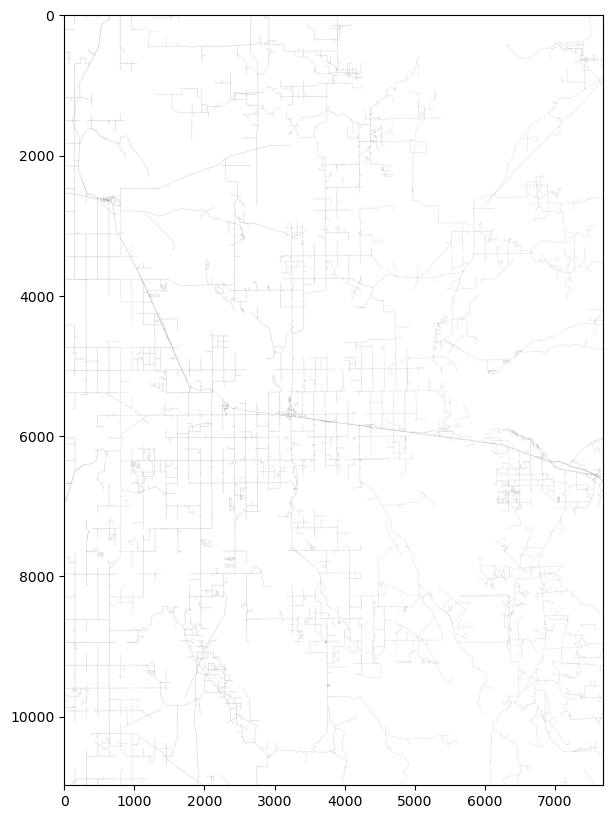

In [7]:
plt.figure(figsize=(8, 10))
plt.imshow(train_mask.permute(1, 2, 0))
plt.show()

In [8]:
new_train_mask = torch.zeros(train_mask.shape, dtype=torch.uint8)
new_train_mask[:, torch.logical_and(torch.logical_and(train_mask[0, :] < 250, train_mask[1, :] < 250), train_mask[2, :] < 250)] = 255
new_train_mask.shape

torch.Size([3, 10980, 7686])

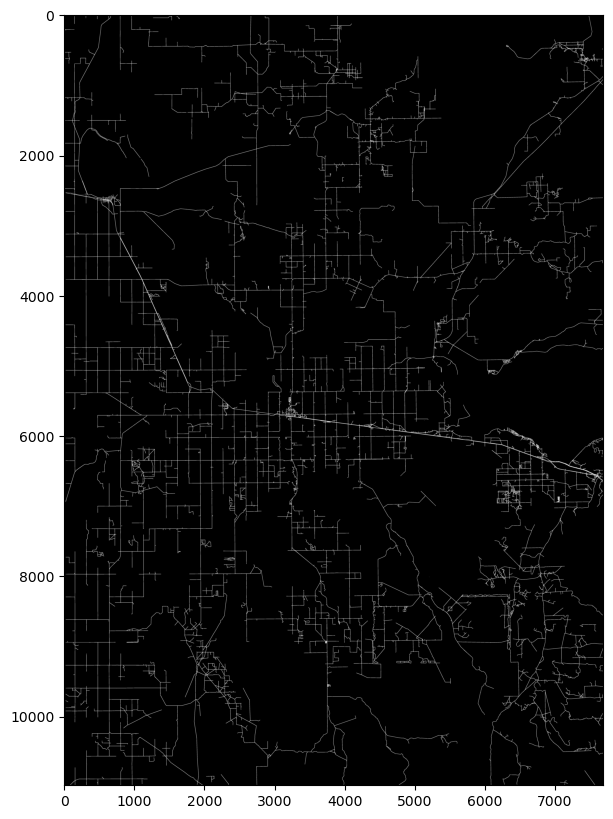

In [9]:
plt.figure(figsize=(8, 10))
plt.imshow(new_train_mask.permute(1, 2, 0))
plt.show()

In [10]:
train_mask = new_train_mask

In [11]:
train_image = train_image.float()/255
train_mask = train_mask.float()/255

____

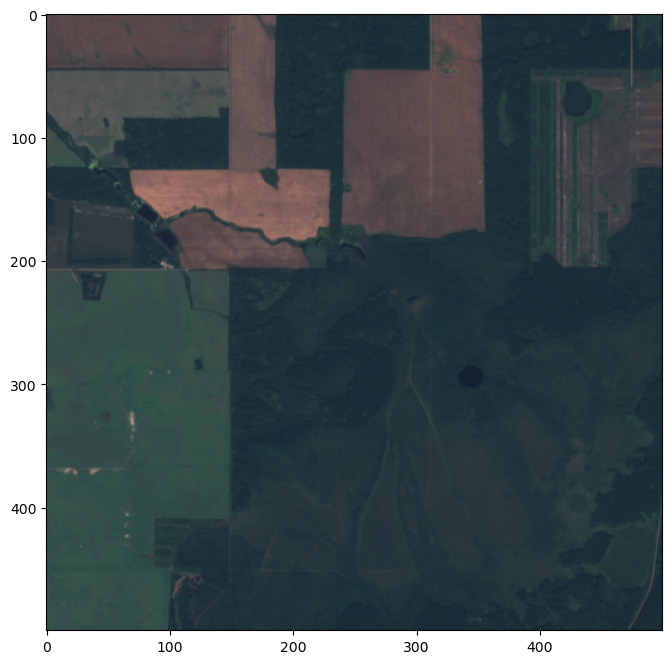

In [12]:
plt.figure(figsize=(8, 8))
plt.imshow(train_image[:, :500, :500].permute(1, 2, 0))
plt.show()

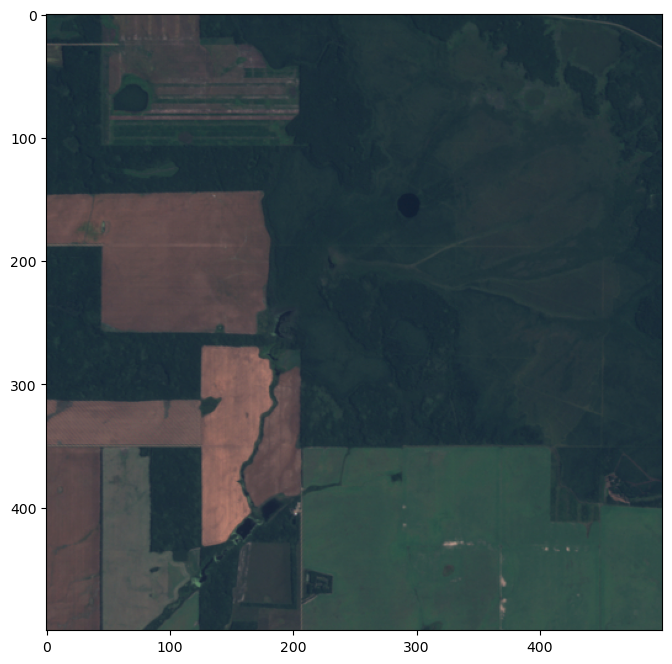

In [13]:
plt.figure(figsize=(8, 8))
plt.imshow(torch.rot90(train_image[:, :500, :500], 1, [1, 2]).permute(1, 2, 0))
plt.show()

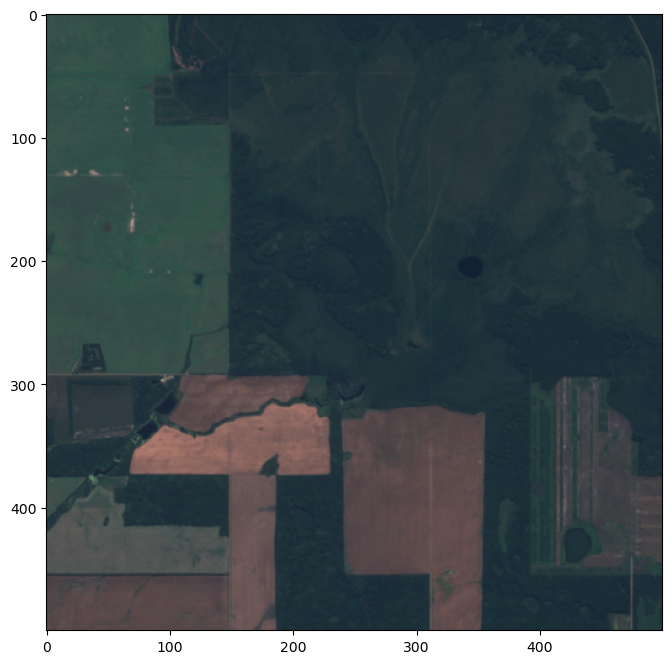

In [14]:
plt.figure(figsize=(8, 8))
plt.imshow(torch.flip(train_image[:, :500, :500], [1]).permute(1, 2, 0))
plt.show()

____

In [15]:
path = './data/train/'
count = 0
for i in range(0, train_image.shape[1], 250):
    for j in range(0, train_image.shape[2], 250):
        if i + 500 <= train_image.shape[1] and j + 500 <= train_image.shape[2]:
            img = train_image[:, i : i + 500, j : j + 500]
            m = train_mask[:, i : i + 500, j : j + 500]

            torchvision.utils.save_image(img, path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(m, path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
            
            torchvision.utils.save_image(torch.rot90(img, 1, [1, 2]), path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(torch.rot90(m, 1, [1, 2]), path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
        
            torchvision.utils.save_image(torch.rot90(img, 2, [1, 2]), path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(torch.rot90(m, 2, [1, 2]), path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
                                                     
            torchvision.utils.save_image(torch.rot90(img, 3, [1, 2]), path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(torch.rot90(m, 3, [1, 2]), path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
            
            img = torch.flip(img, [1])
            m = torch.flip(m, [1])
            
            torchvision.utils.save_image(img, path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(m, path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
            
            torchvision.utils.save_image(torch.rot90(img, 1, [1, 2]), path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(torch.rot90(m, 1, [1, 2]), path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
        
            torchvision.utils.save_image(torch.rot90(img, 2, [1, 2]), path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(torch.rot90(m, 2, [1, 2]), path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
                                                     
            torchvision.utils.save_image(torch.rot90(img, 3, [1, 2]), path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(torch.rot90(m, 3, [1, 2]), path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1

count        

9744

In [16]:
df = pd.DataFrame(columns=['image', 'mask'])
for i in range(0, count):
    df.loc[i] = ['images/' + 'img_' + str(i) + '.jpg', 'masks/' + 'm_' + str(i) + '.jpg']

df.to_csv('./data/train/train_info.csv', index=False)

df

,image,mask
0,images/img_0.jpg,masks/m_0.jpg
1,images/img_1.jpg,masks/m_1.jpg
2,images/img_2.jpg,masks/m_2.jpg
3,images/img_3.jpg,masks/m_3.jpg
4,images/img_4.jpg,masks/m_4.jpg
...,...,...
9739,images/img_9739.jpg,masks/m_9739.jpg
9740,images/img_9740.jpg,masks/m_9740.jpg
9741,images/img_9741.jpg,masks/m_9741.jpg
9742,images/img_9742.jpg,masks/m_9742.jpg


## Validation [0:10980, 7686:9333]

In [17]:
val_image = image[:, :, 7686:9333]
val_mask = mask[:, :, 7686:9333]

In [18]:
val_image.shape

torch.Size([3, 10980, 1647])

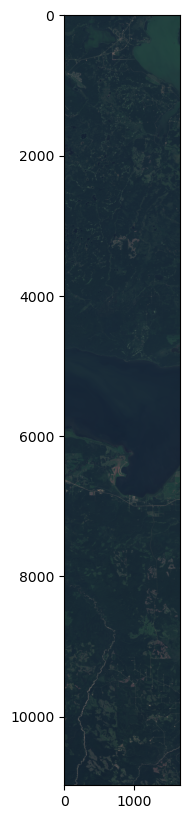

In [19]:
plt.figure(figsize=(3, 10))
plt.imshow(val_image.permute(1, 2, 0))
plt.show()

In [20]:
val_mask.shape

torch.Size([3, 10980, 1647])

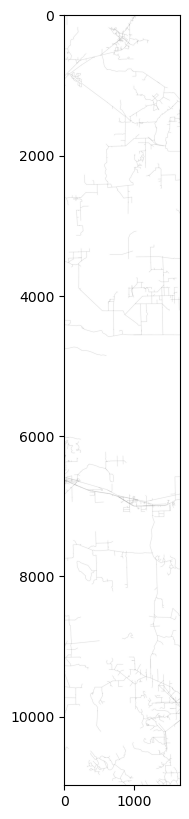

In [21]:
plt.figure(figsize=(3, 10))
plt.imshow(val_mask.permute(1, 2, 0))
plt.show()

In [22]:
new_val_mask = torch.zeros(val_mask.shape, dtype=torch.uint8)
new_val_mask[:, torch.logical_and(torch.logical_and(val_mask[0, :] < 250, val_mask[1, :] < 250), val_mask[2, :] < 250)] = 255
new_val_mask.shape

torch.Size([3, 10980, 1647])

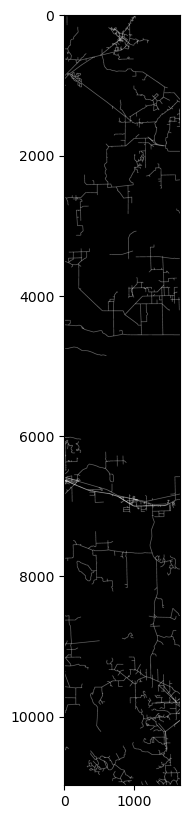

In [23]:
plt.figure(figsize=(3, 10))
plt.imshow(new_val_mask.permute(1, 2, 0))
plt.show()

In [24]:
val_mask = new_val_mask

In [25]:
val_image = val_image.float()/255
val_mask = val_mask.float()/255

____

In [26]:
path = './data/validation/'
count = 0
for i in range(0, val_image.shape[1], 250):
    for j in range(0, val_image.shape[2], 250):
        if i + 500 <= val_image.shape[1] and j + 500 <= val_image.shape[2]:
            img = val_image[:, i : i + 500, j : j + 500]
            m = val_mask[:, i : i + 500, j : j + 500]

            torchvision.utils.save_image(img, path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(m, path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
            
            torchvision.utils.save_image(torch.rot90(img, 1, [1, 2]), path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(torch.rot90(m, 1, [1, 2]), path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
        
            torchvision.utils.save_image(torch.rot90(img, 2, [1, 2]), path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(torch.rot90(m, 2, [1, 2]), path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
                                                     
            torchvision.utils.save_image(torch.rot90(img, 3, [1, 2]), path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(torch.rot90(m, 3, [1, 2]), path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
            
            img = torch.flip(img, [1])
            m = torch.flip(m, [1])
            
            torchvision.utils.save_image(img, path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(m, path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
            
            torchvision.utils.save_image(torch.rot90(img, 1, [1, 2]), path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(torch.rot90(m, 1, [1, 2]), path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
        
            torchvision.utils.save_image(torch.rot90(img, 2, [1, 2]), path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(torch.rot90(m, 2, [1, 2]), path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
                                                     
            torchvision.utils.save_image(torch.rot90(img, 3, [1, 2]), path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(torch.rot90(m, 3, [1, 2]), path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1

count        

1680

In [27]:
df = pd.DataFrame(columns=['image', 'mask'])
for i in range(0, count):
    df.loc[i] = ['images/' + 'img_' + str(i) + '.jpg', 'masks/' + 'm_' + str(i) + '.jpg']

df.to_csv('./data/validation/validation_info.csv', index=False)

df

,image,mask
0,images/img_0.jpg,masks/m_0.jpg
1,images/img_1.jpg,masks/m_1.jpg
2,images/img_2.jpg,masks/m_2.jpg
3,images/img_3.jpg,masks/m_3.jpg
4,images/img_4.jpg,masks/m_4.jpg
...,...,...
1675,images/img_1675.jpg,masks/m_1675.jpg
1676,images/img_1676.jpg,masks/m_1676.jpg
1677,images/img_1677.jpg,masks/m_1677.jpg
1678,images/img_1678.jpg,masks/m_1678.jpg


## Test [0:10980, 9333:10980]

In [28]:
test_image = image[:, :, 9333:]
test_mask = mask[:, :, 9333:]

In [29]:
test_image.shape

torch.Size([3, 10980, 1647])

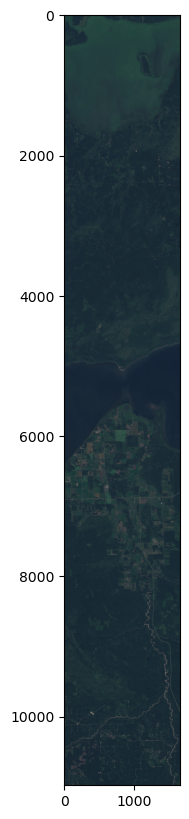

In [30]:
plt.figure(figsize=(3, 10))
plt.imshow(test_image.permute(1, 2, 0))
plt.show()

In [31]:
test_mask.shape

torch.Size([3, 10980, 1647])

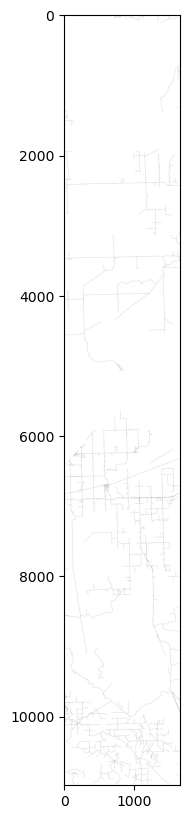

In [32]:
plt.figure(figsize=(3, 10))
plt.imshow(test_mask.permute(1, 2, 0))
plt.show()

In [33]:
new_test_mask = torch.zeros(test_mask.shape, dtype=torch.uint8)
new_test_mask[:, torch.logical_and(torch.logical_and(test_mask[0, :] < 250, test_mask[1, :] < 250), test_mask[2, :] < 250)] = 255
new_test_mask.shape

torch.Size([3, 10980, 1647])

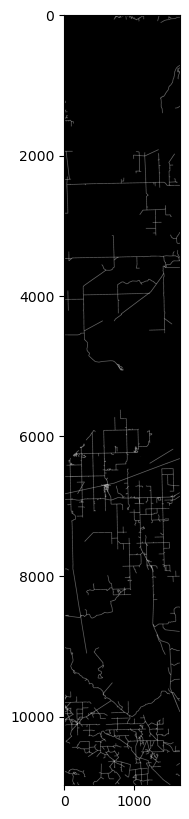

In [34]:
plt.figure(figsize=(3, 10))
plt.imshow(new_test_mask.permute(1, 2, 0))
plt.show()

In [35]:
test_mask = new_test_mask

In [36]:
test_image = test_image.float()/255
test_mask = test_mask.float()/255

____

In [37]:
path = './data/test/'
count = 0
for i in range(0, test_image.shape[1], 250):
    for j in range(0, test_image.shape[2], 250):
        if i + 500 <= test_image.shape[1] and j + 500 <= test_image.shape[2]:
            img = test_image[:, i : i + 500, j : j + 500]
            m = test_mask[:, i : i + 500, j : j + 500]

            torchvision.utils.save_image(img, path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(m, path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
            
            torchvision.utils.save_image(torch.rot90(img, 1, [1, 2]), path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(torch.rot90(m, 1, [1, 2]), path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
        
            torchvision.utils.save_image(torch.rot90(img, 2, [1, 2]), path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(torch.rot90(m, 2, [1, 2]), path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
                                                     
            torchvision.utils.save_image(torch.rot90(img, 3, [1, 2]), path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(torch.rot90(m, 3, [1, 2]), path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
            
            img = torch.flip(img, [1])
            m = torch.flip(m, [1])
            
            torchvision.utils.save_image(img, path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(m, path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
            
            torchvision.utils.save_image(torch.rot90(img, 1, [1, 2]), path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(torch.rot90(m, 1, [1, 2]), path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
        
            torchvision.utils.save_image(torch.rot90(img, 2, [1, 2]), path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(torch.rot90(m, 2, [1, 2]), path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1
                                                     
            torchvision.utils.save_image(torch.rot90(img, 3, [1, 2]), path + 'images/' + 'img_' + str(count) + '.jpg')
            torchvision.utils.save_image(torch.rot90(m, 3, [1, 2]), path + 'masks/' + 'm_' + str(count) + '.jpg')
            count += 1

count        

1680

In [38]:
df = pd.DataFrame(columns=['image', 'mask'])
for i in range(0, count):
    df.loc[i] = ['images/' + 'img_' + str(i) + '.jpg', 'masks/' + 'm_' + str(i) + '.jpg']

df.to_csv('./data/test/test_info.csv', index=False)

df

,image,mask
0,images/img_0.jpg,masks/m_0.jpg
1,images/img_1.jpg,masks/m_1.jpg
2,images/img_2.jpg,masks/m_2.jpg
3,images/img_3.jpg,masks/m_3.jpg
4,images/img_4.jpg,masks/m_4.jpg
...,...,...
1675,images/img_1675.jpg,masks/m_1675.jpg
1676,images/img_1676.jpg,masks/m_1676.jpg
1677,images/img_1677.jpg,masks/m_1677.jpg
1678,images/img_1678.jpg,masks/m_1678.jpg
